# Simple regression models - ShoreShop 2.0

Some simple regression models from old code. These are a nice baseline to explore the data, and get a feel for the process and alongshore behaviour. 
The code I have has the models estimate parameters for dx and then model y as:

`y = jnp.cumsum(f(x)) + e`

In [1]:
# magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from functions.data_load import load_modelling_data, tabularise_raw_data

from functions.inference.utils import (
    calc_skill,
    print_skill,
    transform_data_to_jax,
    prepare_resample_monthly_data
)

## Load the data

Load the data using `load_modelling_data()` that returns a dictionary containing the following pandas DataFrames mirroring `1.data_explore.ipynb` (with indices as datetime objects where possible):

- `df_tran`: Transect data.
- `df_gt`: Groundtruth shoreline positions.
- `df_targ_short`: Short-term target shoreline positions.
- `df_targ_medium`: Medium-term target shoreline positions.
- `df_obs`: Observed shoreline positions.
- `dfs_wave`: Wave data for different parameters ('Hs', 'Tp', 'Dir').
- `df_SLR_obs`: Observed sea level rise data.
- `df_SLR_proj`: Projected sea level rise data.

Provided information:
A sequence of shore-normal transects were defined from North to South.\
The distance between transects is 100 m alongshore\
The coordinates of transects were intentionally shifted.

Shoreline positions were retrieved from Landsat 5, 7, 8 and 9 satellite images with [CoastSat toolbox](https://github.com/kvos/CoastSat/tree/master).\
All the shorelines have been corrected to reflect the instaneous position at Mean Sea Level\
Only shorelines from 1987 to 2018 are avaiable for model training/calibration in this site.\
Along each transect, shoreline positions were provided as the distance to the **landward** end of the transect.

Offshore wave data is from [ERA5](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview) wave spectra data.\
SWAN model was used to transfer offshore wave into nearshore with [Binwave](https://www.sciencedirect.com/science/article/pii/S1463500324000337) approach developed by Dr Laura Cagigal.\
Along each transect, the wave data was extracted at 10m contour 

In [3]:
basedir = '.' # where are you in relation to the root directory
raw_data = load_modelling_data(basedir=basedir)

df_tran: Loaded 9 transects...
df_gt: Loaded (3, 9) (dates,transects) groundtruth shoreline positions...1999-06-20 to 2018-08-17
df_targ_short: Loaded (119, 9) (dates,transects) short-term target shoreline positions...2018-11-04 to 2023-12-28
df_targ_medium: Loaded (114, 9) (dates,transects) medium-term target shoreline positions...1951-05-01 to 1998-10-27
df_obs: Loaded (347, 9) (dates,transects) observed shoreline positions...1999-02-17 to 2018-12-30
dfs_wave["Hs"]: Loaded (30678, 9) (dates,transects) Hs wave data...
dfs_wave["Tp"]: Loaded (30678, 9) (dates,transects) Tp wave data...
dfs_wave["Dir"]: Loaded (30678, 9) (dates,transects) Dir wave data...
Wave data spans: 1940-01-02 to 2023-12-29 at 1 day(s) interval
df_SLR_obs: Loaded (69, 1) (years, ['Sealevel (m)']) observed sea level rise data...1950 to 2018
df_SLR_proj: Loaded (81, 2) (years, ['RCP45', 'RCP85']) projected sea level rise data...2019 to 2099


## Optional preprocessing
Here is provided a template for optional preprocessing steps that can be used to tabularise the data for modelling. Adopted the frequency of the wave data, but this can of course be adjusted.

In [4]:
# Optional pre-processing
tabular_data = tabularise_raw_data(raw_data)

<Axes: xlabel='date', ylabel='shoreline'>

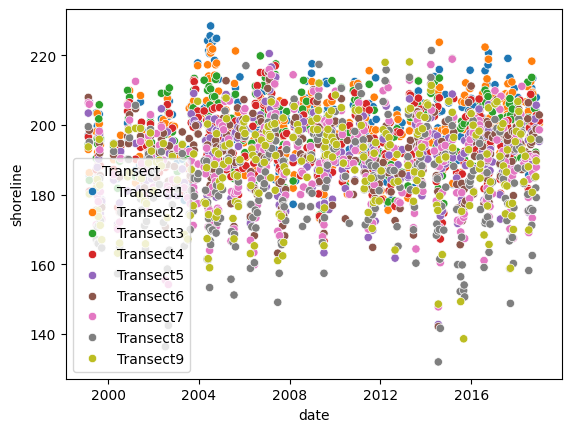

In [5]:
sns.scatterplot(tabular_data['df_obs'], hue='Transect', x='date', y='shoreline')

### Quick visualisation
Some quick visualisation of the data to show the format

We have daily data with intermittent shoreline position at 9 transects.

In [6]:
print(tabular_data.keys())
print(tabular_data['df_obs']['Transect'].unique())
tabular_data['df_obs']

# not a huge difference
# tabular_data['df_obs'].loc[tabular_data['df_obs']['Dir']>180,'Dir'] = np.nan
# #interpolate the missing values in 'Dir'
# tabular_data['df_obs']['Dir'] = tabular_data['df_obs']['Dir'].interpolate()

# Hs = log(Hs) - dont do here
# tabular_data['df_obs']['Hs'] = np.log(tabular_data['df_obs']['Hs'])

dict_keys(['df_obs', 'df_targ_short', 'df_targ_medium'])
['Transect1' 'Transect2' 'Transect3' 'Transect4' 'Transect5' 'Transect6'
 'Transect7' 'Transect8' 'Transect9']


date   Transect   shoreline        Hs         Tp         Dir
0     1999-02-17  Transect1  197.025794  1.278391  10.180599   87.879170
1     1999-02-18  Transect1         NaN  1.613118  10.515673  109.377224
2     1999-02-19  Transect1         NaN  1.384905  10.275089  127.935891
3     1999-02-20  Transect1         NaN  0.965775   9.764103  110.974377
4     1999-02-21  Transect1         NaN  1.222583   9.606054  106.006189
...          ...        ...         ...       ...        ...         ...
65308 2018-12-26  Transect9         NaN  1.200796  10.247938   99.339025
65309 2018-12-27  Transect9         NaN  1.208491   6.375795   85.126659
65310 2018-12-28  Transect9         NaN  1.313490   7.214175   71.430210
65311 2018-12-29  Transect9         NaN  1.338269   7.584354   73.688101
65312 2018-12-30  Transect9         NaN  1.048934   8.127162   76.919301

[65313 rows x 6 columns]

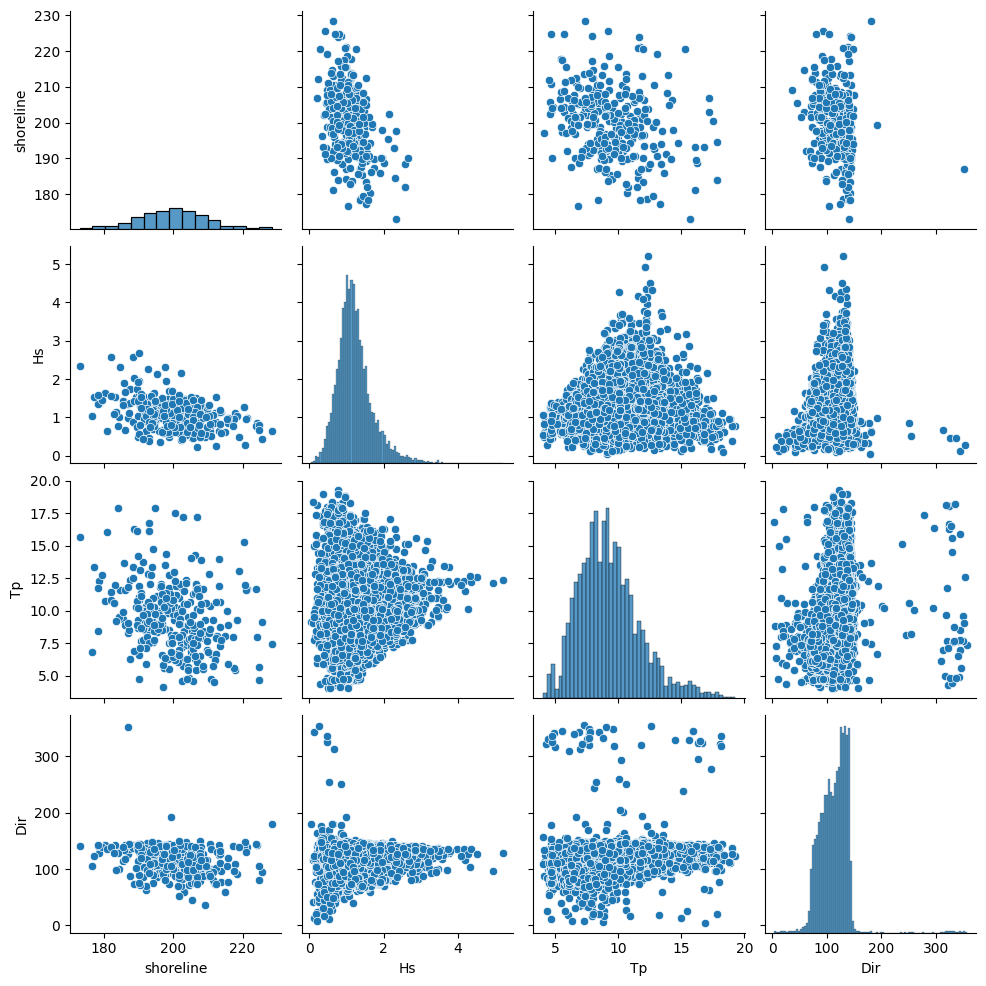

In [7]:
# pairplot the data
trans_id = 'Transect1'
sns.pairplot(
    tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect','date'])
)
plt.show()

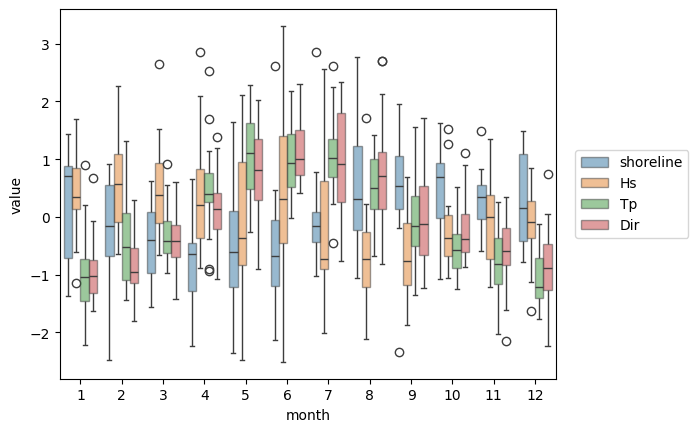

In [8]:
# plot the seasonal averages
trans_id = 'Transect1'
plot_data = tabular_data['df_obs'].query('Transect == @trans_id').drop(columns=['Transect']).set_index('date').resample('1ME').mean()
plot_data = plot_data.assign(month=plot_data.index.month)
# demean and stanardise the variables
for _ in [_ for _ in plot_data.columns if not _ in ['month']]:
    plot_data[_] = (plot_data[_] - plot_data[_].mean())/plot_data[_].std()
sns.boxplot(data=plot_data.melt(id_vars='month'),x='month',y='value',hue='variable',boxprops=dict(alpha=.5))
plt.legend(loc=6,bbox_to_anchor=(1.025,0.5))
plt.show()

## Modelling attempt
Here you can construct your model and make some predictions.

In [9]:
# cpu cores available for sampling (we want this to equal num_chains)
os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=4'

# NumPyro for proabilistic programming
import arviz as az
import jax
from jax import random
import jax.numpy as jnp

# Local functions
from functions.inference import NumPyroSampler
from functions.np_plotting import plot_prediction_scatter, plot_prediction

from functions.models import (
    build_seasonal_linear_model,
    build_shladj_linear_model
)

### Prepare the data
Initially I will resample to monthly to avoid so many NaNs and other unpleasantries. Then we will cheekily gap fill the data, this will be a big exercise in missing data and the choice around how this is handled needs to be considered carefully.

In [10]:
# split per Transect then average to monthly values with mean and peak for Hs and Tp then recombine into a reasonable dataframe
resampled_data = prepare_resample_monthly_data(tabular_data['df_obs'])

# SHORT TEST
target_name = 'short'
# LONG TEST
# target_name = 'medium'

target_data = tabular_data['df_targ_{}'.format(target_name)]
# target_raw_data = raw_data['df_targ_{}'.format(target_name)]

resampled_test_data = prepare_resample_monthly_data(target_data)

print(resampled_data.head())
print(resampled_test_data.head())

        date   Hs_mean    Hs_max    Tp_mean     Tp_max    Dir_mean  \
0 1999-02-01  0.507837  0.987777  10.288477  11.371681  110.466204   
1 1999-03-01  0.258330  0.621925   8.780990  16.435893  110.464774   
2 1999-04-01  0.572349  1.325001  10.478596  16.203715  122.393067   
3 1999-05-01  0.178583  1.028514  10.827863  18.867008  106.549393   
4 1999-06-01  0.221592  0.753507   9.277906  12.247637  125.319169   

    shoreline   Transect  month  
0  197.025794  Transect1      1  
1  185.473336  Transect1      2  
2         NaN  Transect1      3  
3         NaN  Transect1      4  
4  203.434419  Transect1      5  
        date   Hs_mean    Hs_max   Tp_mean     Tp_max    Dir_mean   shoreline  \
0 2018-11-01  0.183838  0.950867  8.768352  18.785477  115.056343  204.162356   
1 2018-12-01  0.252364  0.641846  8.023790  10.184250   96.851160         NaN   
2 2019-01-01  0.161207  0.558559  7.615040  14.570347   93.486631         NaN   
3 2019-02-01  0.327864  0.719416  8.032775  12.3962

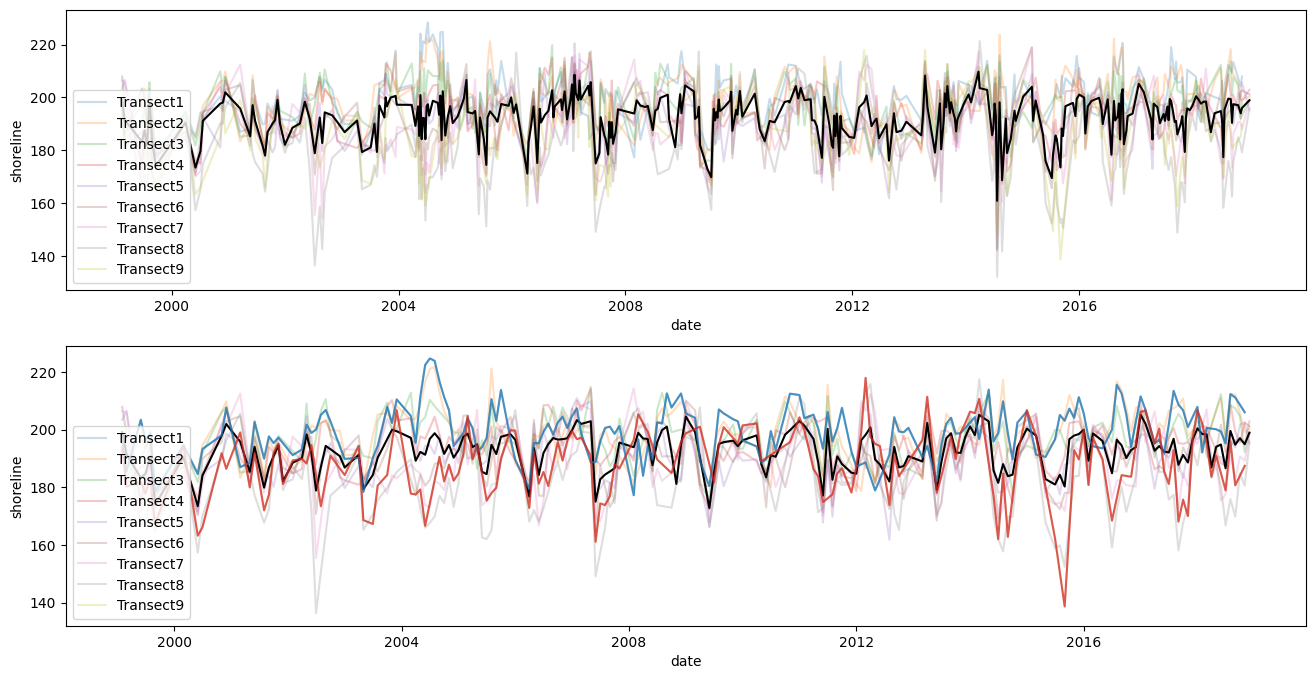

In [11]:
# vis of transect data
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.lineplot(data=tabular_data['df_obs'],y='shoreline',x='date', hue='Transect', ax=ax1, alpha=0.25)
sns.lineplot(data=tabular_data['df_obs'],y='shoreline',x='date', ax=ax1, color = 'k', errorbar=None)

sns.lineplot(data=resampled_data,y='shoreline', x='date', hue='Transect', ax=ax2, alpha=0.25)
sns.lineplot(data=resampled_data,y='shoreline', x='date', ax=ax2, color = 'k', errorbar=None)
sns.lineplot(data=resampled_data.query('Transect == "Transect1"'),y='shoreline', x='date', color = 'C0', ax=ax2, alpha=0.75)
sns.lineplot(data=resampled_data.query('Transect == "Transect9"'),y='shoreline', x='date', color = 'C3', ax=ax2, alpha=0.75)
plt.show()



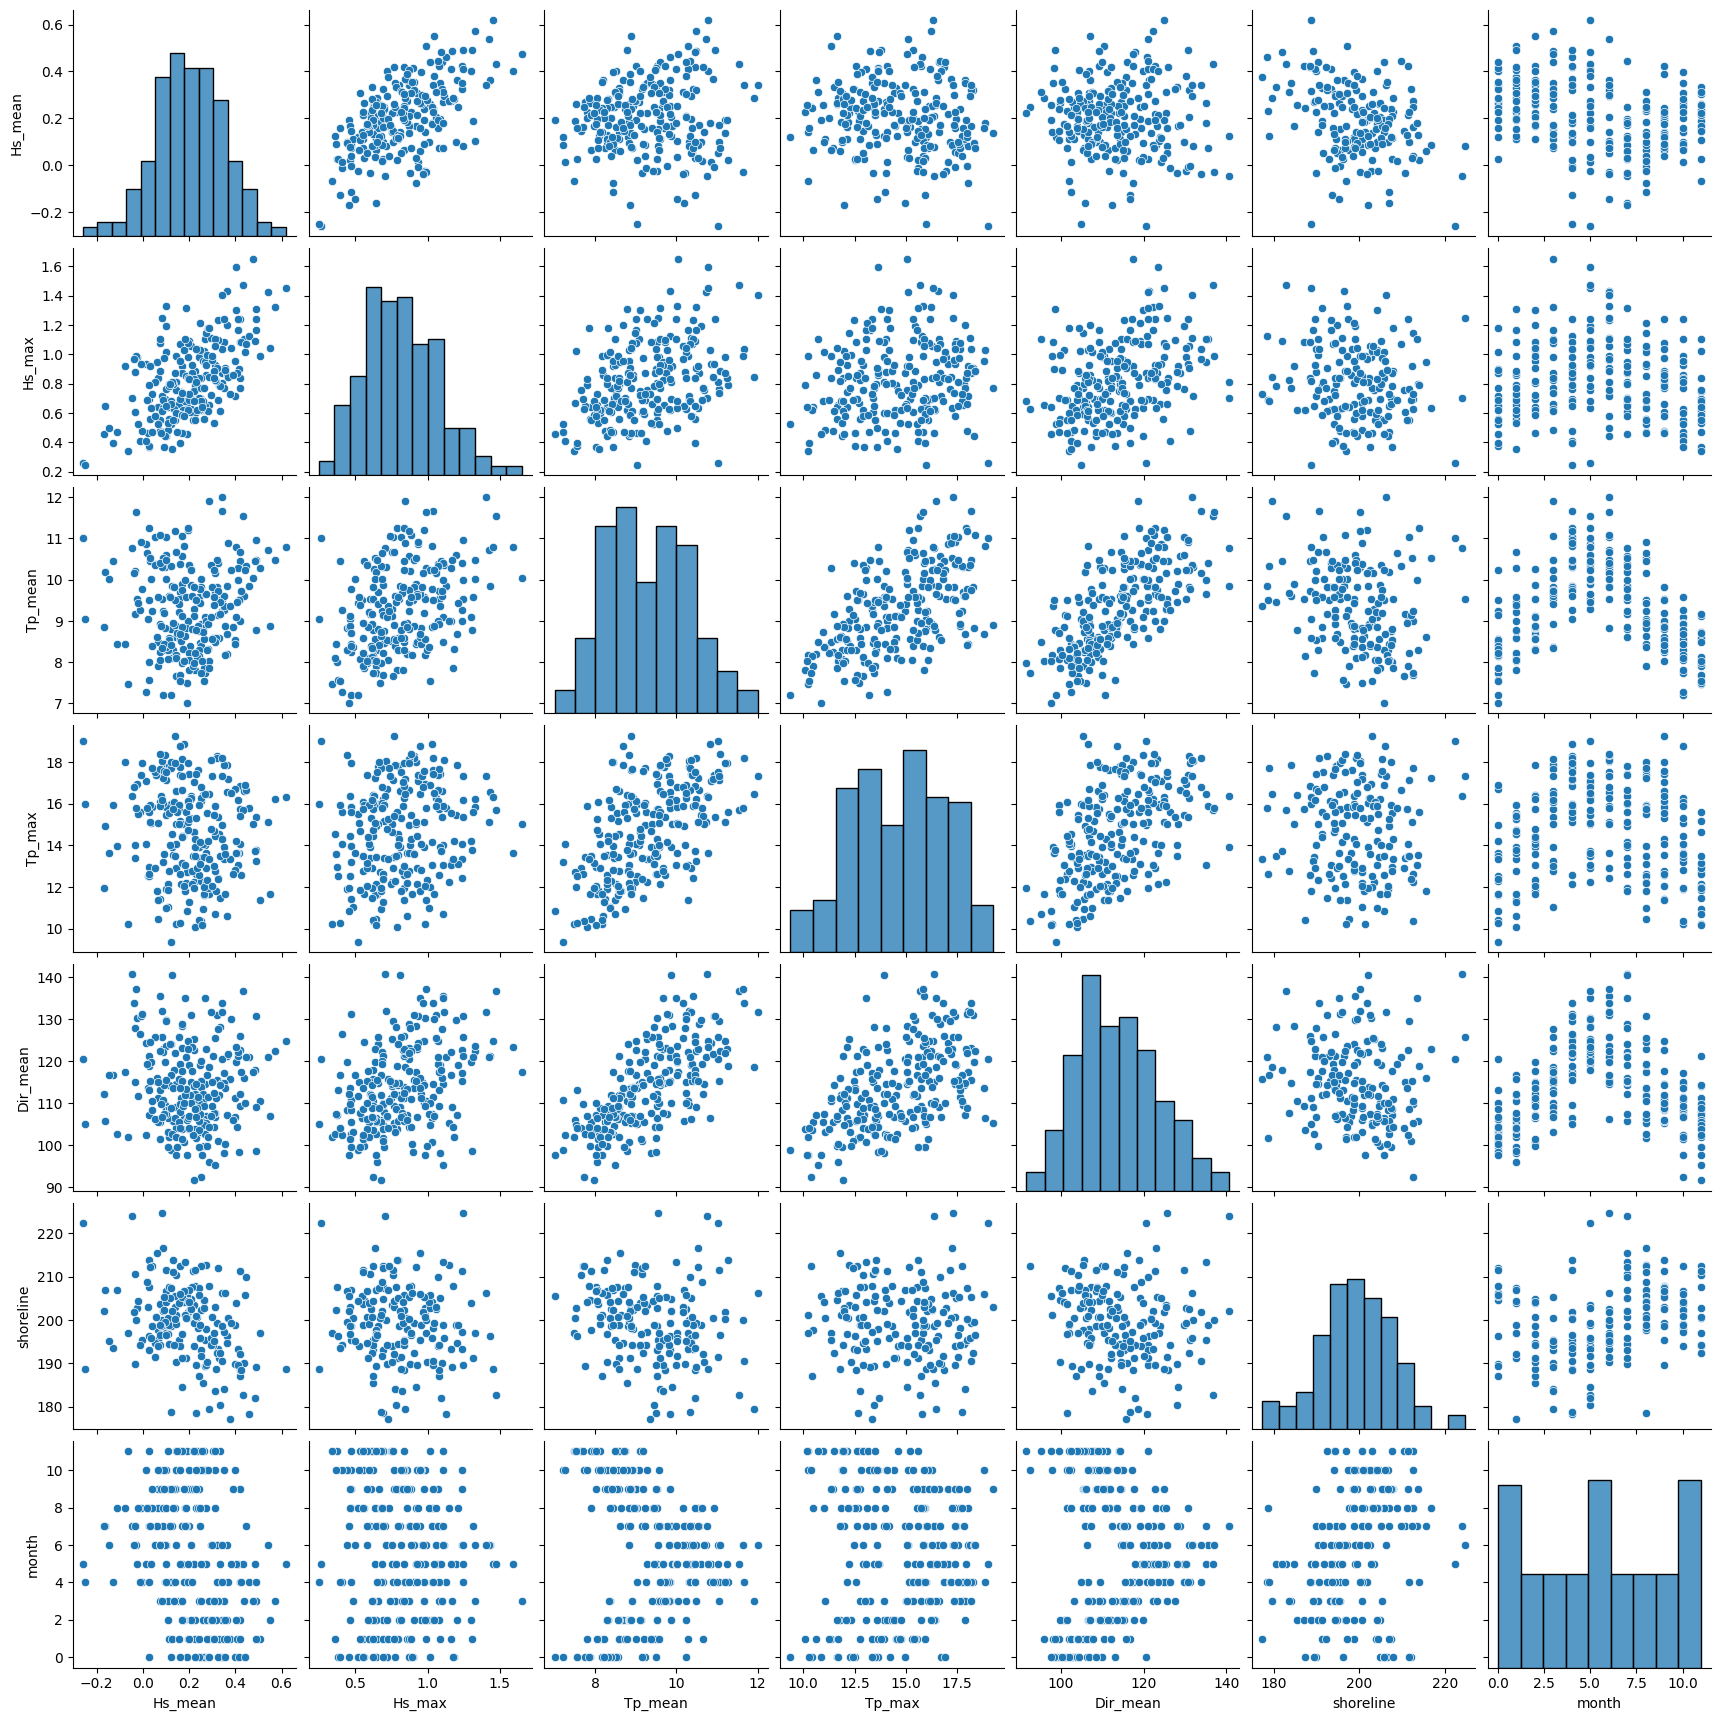

In [12]:
# pairplot the data
trans_id = 'Transect1'
sns.pairplot(
    resampled_data.query('Transect == @trans_id').drop(columns=['Transect','date'])
)
plt.show()

In [13]:
resampled_data

date   Hs_mean    Hs_max    Tp_mean     Tp_max    Dir_mean  \
0    1999-02-01  0.507837  0.987777  10.288477  11.371681  110.466204   
1    1999-03-01  0.258330  0.621925   8.780990  16.435893  110.464774   
2    1999-04-01  0.572349  1.325001  10.478596  16.203715  122.393067   
3    1999-05-01  0.178583  1.028514  10.827863  18.867008  106.549393   
4    1999-06-01  0.221592  0.753507   9.277906  12.247637  125.319169   
...         ...       ...       ...        ...        ...         ...   
2146 2018-08-01  0.011187  0.930940  10.716873  15.233035  115.534353   
2147 2018-09-01  0.101651  0.526518   9.220982  15.896701  113.840845   
2148 2018-10-01  0.358182  0.833160   9.086596  16.123380  107.333152   
2149 2018-11-01  0.135998  0.948332   8.718028  18.943418  113.744590   
2150 2018-12-01  0.219860  0.580225   8.073912  10.247938   99.292942   

       shoreline   Transect  month  
0     197.025794  Transect1      1  
1     185.473336  Transect1      2  
2            NaN  Transect1      3  
3            NaN  Transect1      4  
4     203.434419  Transect1      5  
...          ...        ...    ...  
2146  195.940861  Transect9      7  
2147  180.674962  Transect9      8  
2148         NaN  Transect9      9  
2149  187.439058  Transect9     10  
2150         NaN  Transect9     11  

[2151 rows x 9 columns]

In [14]:
x_vars = ['Hs_mean','Hs_max','Tp_mean','Tp_max','Dir_mean','month']
y_vars = ['shoreline']
tran_var = 'Transect'

split_date = '2009-01-01'
# split_date = '2015-01-01'

# Make standardised data - split by date for some train/validation
# jnp_X, jnp_Y, jnp_Ym1, df_Y, scalers = transform_data_to_jax(
#     resampled_data.query('date < "{}"'.format(split_date)),
#     x_vars, y_vars, tran_var,
#     standardise=True
# )

# jnp_X_test, jnp_Y_test, jnp_Ym1_test, df_Y_test, scalers = transform_data_to_jax(
#     resampled_data.query('date >= "{}"'.format(split_date)),
#     x_vars, y_vars, tran_var,
#     standardise=True,
#     scaler_x=scalers['scaler_x'],
#     scaler_y=scalers['scaler_y']
# )

# Make standardised data
jnp_X, jnp_Y, jnp_Ym1, df_Y, scalers = transform_data_to_jax(
    resampled_data,
    x_vars, y_vars, tran_var,
    standardise=True
)

# Unseen test data
jnp_X_test, jnp_Y_test, jnp_Ym1_test, df_Y_test, scalers = transform_data_to_jax(
    resampled_test_data,
    x_vars, y_vars, tran_var,
    standardise=True,
    interp_y=False,
    scaler_x=scalers['scaler_x'],
    scaler_y=scalers['scaler_y']
)

Unique transects: ['Transect1' 'Transect2' 'Transect3' 'Transect4' 'Transect5' 'Transect6'
 'Transect7' 'Transect8' 'Transect9']
jnp_X.shape: (238, 9, 6), isnan: 0
jnp_Y.shape: (238, 9), isnan: 0
jnp_T.shape: (2151,), isnan: 0
jnp_Ym1.shape: (238, 9), isnan: 0
Unique transects: ['Transect1' 'Transect2' 'Transect3' 'Transect4' 'Transect5' 'Transect6'
 'Transect7' 'Transect8' 'Transect9']
jnp_X.shape: (61, 9, 6), isnan: 0
jnp_Y.shape: (61, 9), isnan: 549
jnp_T.shape: (558,), isnan: 0
jnp_Ym1.shape: (61, 9), isnan: 540


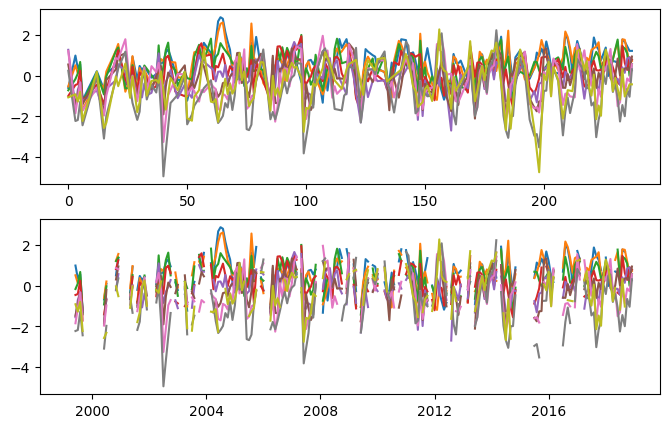

In [15]:
# check a plot of df_Y vs jnp_Y
fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(jnp_Y)
ax2.plot(df_Y)
plt.show()


### Prepare the models and check priors
We will compare several models, at first just trying to build the most basic model (seasonal) as a baseline for more complex models. The idea is to keep the models simple regression constructions rather than jumping to non-linear setups. The aim is to tell a story with the simplest of models to see how much more perfomance can be wringed out when compared to others' more complex models.

- `linear_seasonal_model`: Seasonal term with more flexibility (param learned for each transect/month) and linear trend.
- `linear_shladj_model`: Seasonal term with more flexibility (param learned for each transect/month), linear trend, and wave data (Hsig, Tp, Dir) as input.

In [16]:
ci = 0.89

# a lazy but more flexible way to code in seasonality creating a lot of new params.
linear_seasonal_model = build_seasonal_linear_model()
# define sampler
linear_seasonal_sampler = NumPyroSampler(
    jnp_X,
    jnp_Y,
    jnp_Ym1,
    model=linear_seasonal_model,
    ci=ci,
    seed=2024
)

# simple linear model
linear_shladj_model = build_shladj_linear_model()
# define sampler
linear_shladj_sampler = NumPyroSampler(
    jnp_X,
    jnp_Y,
    jnp_Ym1,
    model=linear_shladj_model,
    ci=ci,
    seed=2024
)

In [17]:
arviz_priors, prior_predictive = linear_shladj_sampler.prior_predictive_check(num_samples=100)

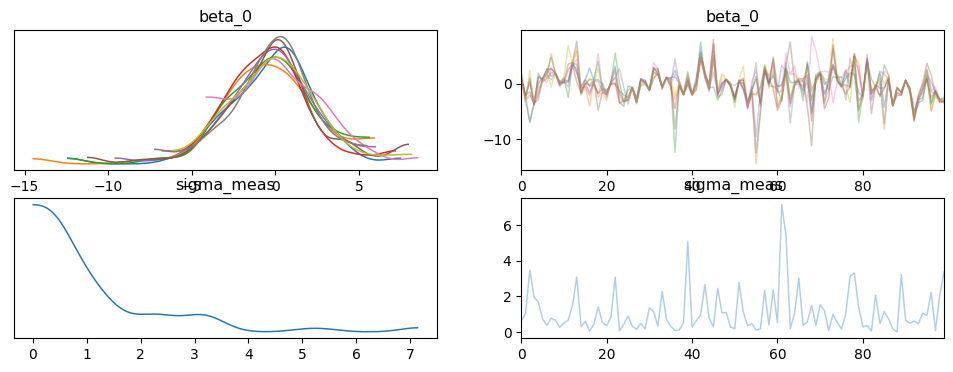

In [18]:
az.plot_trace(arviz_priors.prior, var_names=['beta_0','sigma_meas'])
None

In [19]:
prior_predictive['mean_mu_prior'].shape
jnp_Y.shape

(238, 9)

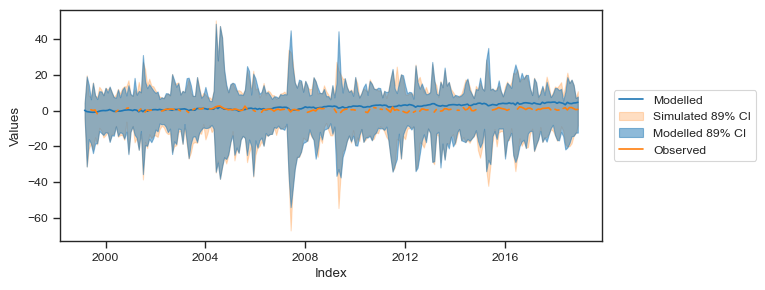

In [20]:
plot_prediction(
    df_Y,
    prior_predictive['mean_mu_prior'],
    prior_predictive['hpdi_mu_prior'],
    prior_predictive['hpdi_sim_prior'],
    tran_id = 1,
    ci=ci
)

### Sample the models
We will sample each of the models using MCMC.

In [21]:
# reparam with loc scale imports
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam

In [22]:
# settings 
sampler_type = 'NUTS'
num_samples = 2000
num_warmup = 2000
num_chains = 4
max_tree = 10
step_size = 0.01 #75
n_train = 5000
n_predictive = n_train
save_bool = False # save to arviz netcdf
load_bool = False # load previous runs from arviz netcdf
extract_vars = ['mu','sigma_meas','obs'] # variables to extract from posterior_predictive
# variables to check in posterior

check_vars = {
    'linear_shladj_model': [
        'beta_month','beta_Hsig_0', 'beta_Hsig_max', 'beta_Hsig_dir', 'beta_Tp_0', 'alpha_Hsig_0', 'alpha_Hsig_max', 'alpha_Hsig_dir', 'alpha_Tp_0'
    ]
}

linear_shladj_model_reparam = reparam(
    linear_shladj_model, LocScaleReparam()
)

kernels_models = {
    'linear_shladj_model': (linear_shladj_sampler,linear_shladj_model_reparam)
}

rng_key_ = random.PRNGKey(2024)

mcmc_outputs = {}
# run the sampler
for model_name, (sampler, model) in kernels_models.items():
    print('Running {}'.format(model_name))
    if sampler_type == 'NUTS':
        sampler.run_sampler(
            rng_key=rng_key_,
            num_samples=num_samples,
            num_warmup=num_warmup,
            num_chains=num_chains,
            max_tree=max_tree,
            extract_vars=extract_vars,
        )
    elif sampler_type == 'SVI':
        sampler.run_sampler_SVI(
            rng_key=rng_key_,
            num_samples=n_train,
            num_chains=num_chains,
            step_size=step_size,
            extract_vars=extract_vars,
        )

    # # get forward predicion
    # results_forward = sampler.predict_forward(
    #     rng_key=rng_key_,
    #     extract_vars=extract_vars
    # )

    mean_mu_test, hpdi_mu_test, hpdi_sim_test = sampler.model_predict(rng_key_, jnp_X_test, jnp_Ym1_test)

    mcmc_outputs[model_name] = {
        'arviz_posterior': sampler.arviz,
        'mean_mu': sampler.results['mean_mu_train'],
        'hpdi_mu': sampler.results['hpdi_mu_train'],
        'hpdi_sim': sampler.results['hpdi_sim_train'],
        'mean_mu_test': mean_mu_test,
        'hpdi_mu_test': hpdi_mu_test,
        'hpdi_sim_test': hpdi_sim_test,
        # 'ts_mean_mu': results_forward['mean_mu'],
        # 'ts_hpdi_mu': results_forward['hpdi_mu'],
        # 'ts_hpdi_sim': results_forward['hpdi_sim'],
        # 'ts_mean_mu_test': results_forward['mean_mu_test'],
        # 'ts_hpdi_mu_test': results_forward['hpdi_mu_test'],
        # 'ts_hpdi_sim_test': results_forward['hpdi_sim_test']
    }


Running linear_shladj_model


/Users/josh/miniconda3/envs/numpyro/lib/python3.10/site-packages/jax/_src/linear_util.py:192: UserWarning: Missing a plate statement for batch dimension -2 at site 'beta_month'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  ans = self.f(*args, **dict(self.params, **kwargs))


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

### Examine the posteriors
Here we can examine the parameters, their posteriors and comapre between models.

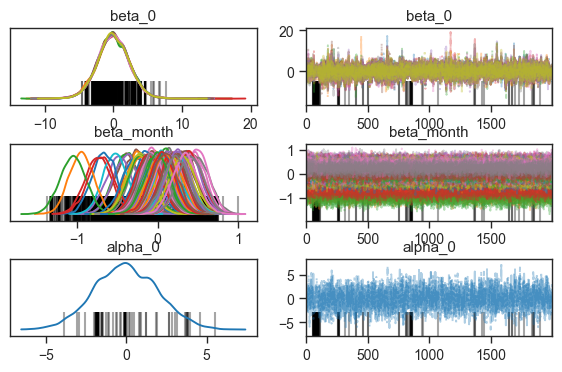

In [23]:
this_model1 = 'linear_shladj_model'
az.plot_trace(
    mcmc_outputs[this_model1]['arviz_posterior'],
    var_names=['beta_0','beta_month', 'alpha_0'],
    # r_hat = True,
    combined=True,
    show=False,
    figsize=(7,4),
)
plt.subplots_adjust(hspace=0.5)

################################################################################
Posterior


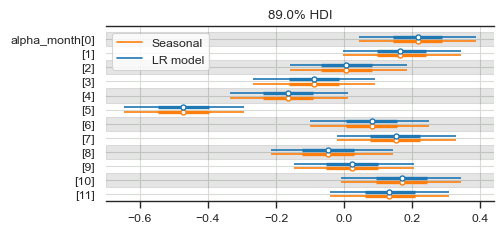

In [24]:
this_model1 = 'linear_shladj_model'
this_model2 = 'linear_shladj_model'
print('#'*80)
print('Posterior')
# sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(211)
az.plot_forest(
    [
        mcmc_outputs[this_model1]['arviz_posterior'],
        mcmc_outputs[this_model2]['arviz_posterior']
    ],
    var_names=['alpha_month'],
    hdi_prob=ci,
    model_names=['LR model','Seasonal'],#,'Mix model'],
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
# turn on grid black with alpha 0.5 for this ax1
ax1.grid(color='xkcd:light grey')
None

################################################################################
Posterior


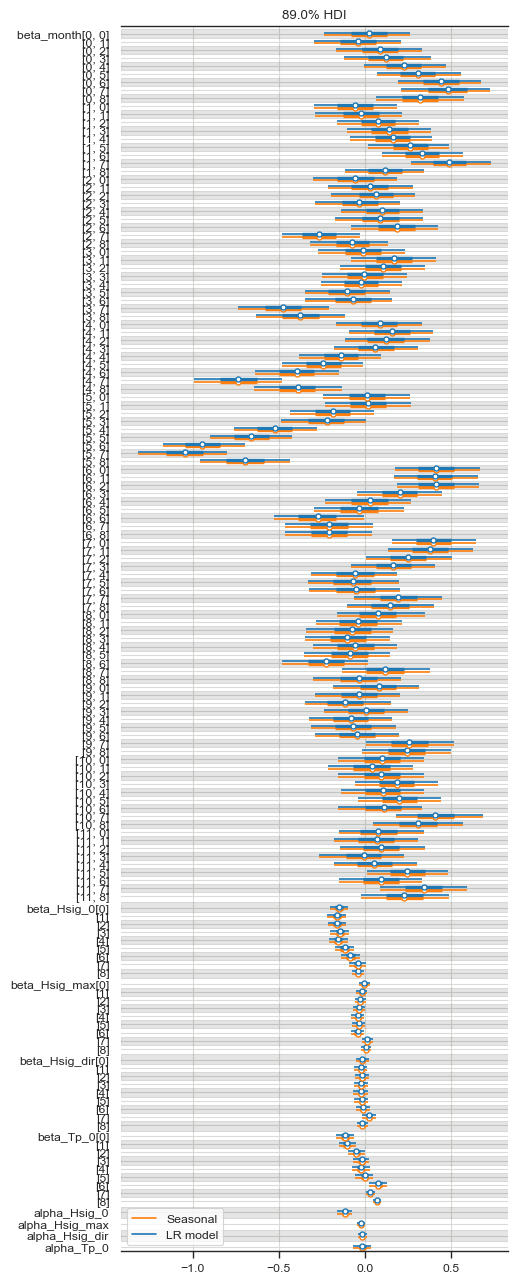

In [25]:
this_model1 = 'linear_shladj_model'
this_model2 = 'linear_shladj_model'
print('#'*80)
print('Posterior')
# sns.set_context('talk')
x_range = 1.5
fig = plt.figure(figsize=(5,35))
ax1 = plt.subplot(211)
az.plot_forest(
    [
        mcmc_outputs[this_model1]['arviz_posterior'],
        mcmc_outputs[this_model2]['arviz_posterior']
    ],
    var_names=check_vars[this_model2],
    hdi_prob=ci,
    model_names=['LR model','Seasonal'],#,'Mix model'],
    # r_hat = True,
    combined=True,
    show=False,
    ax=ax1
)
# turn on grid black with alpha 0.5 for this ax1
ax1.grid(color='xkcd:light grey')
None

In [26]:
# for this_model in mcmc_outputs.keys():
#     print('#'*80)
#     print('Model: {}'.format(this_model))
#     az.plot_trace(
#         mcmc_outputs[this_model]['arviz_posterior'], var_names=check_vars[this_model]
#     )

Check for convergence

In [27]:
if sampler_type == "NUTS":
    for this_model in mcmc_outputs.keys():
        print('#'*80)
        print('Model: {}'.format(this_model))
        display(az.rhat(
            mcmc_outputs[this_model]['arviz_posterior'],
            var_names=check_vars[this_model]
        ))

################################################################################
Model: linear_shladj_model


<xarray.Dataset> Size: 2kB
Dimensions:              (beta_month_dim_0: 12, beta_month_dim_1: 9,
                          beta_Hsig_0_dim_0: 9, beta_Hsig_max_dim_0: 9,
                          beta_Hsig_dir_dim_0: 9, beta_Tp_0_dim_0: 9)
Coordinates:
  * beta_Hsig_0_dim_0    (beta_Hsig_0_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_Hsig_dir_dim_0  (beta_Hsig_dir_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_Hsig_max_dim_0  (beta_Hsig_max_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_Tp_0_dim_0      (beta_Tp_0_dim_0) int64 72B 0 1 2 3 4 5 6 7 8
  * beta_month_dim_0     (beta_month_dim_0) int64 96B 0 1 2 3 4 5 6 7 8 9 10 11
  * beta_month_dim_1     (beta_month_dim_1) int64 72B 0 1 2 3 4 5 6 7 8
Data variables:
    beta_month           (beta_month_dim_0, beta_month_dim_1) float64 864B 1....
    beta_Hsig_0          (beta_Hsig_0_dim_0) float64 72B 1.001 1.0 ... 1.001
    beta_Hsig_max        (beta_Hsig_max_dim_0) float64 72B 1.002 1.0 ... 1.001
    beta_Hsig_dir        (beta_Hsig_dir_dim_0) float64 72B 1.0 1.002 ... 1.002
    beta_Tp_0            (beta_Tp_0_dim_0) float64 72B 1.0 1.0 1.0 ... 1.003 1.0
    alpha_Hsig_0         float64 8B 1.001
    alpha_Hsig_max       float64 8B 1.001
    alpha_Hsig_dir       float64 8B 1.001
    alpha_Tp_0           float64 8B 1.001

## Transform the results back to real shoreline position

### Compare model skill
Compare the skill of each model by RMSE, R2 (of dShl), BSS.

In [28]:
# report the RMSE, BSS and R2
print('#'*80)
print('Train')
print_skill(mcmc_outputs,df_Y,mu_var='mean_mu')
print('Test')
if np.any(~df_Y_test.isna()):
    print_skill(mcmc_outputs,df_Y_test,mu_var='mean_mu_test')
else:
    print('No test y data')
None

################################################################################
Train
# Site 0: Transect1
linear_shladj_model - Transect1: BSS: 0.42 | RMSE: 0.55 | R2: 0.22 | r: 0.69
# Site 1: Transect2
linear_shladj_model - Transect2: BSS: 0.46 | RMSE: 0.58 | R2: 0.16 | r: 0.64
# Site 2: Transect3
linear_shladj_model - Transect3: BSS: 0.57 | RMSE: 0.54 | R2: 0.17 | r: 0.51
# Site 3: Transect4
linear_shladj_model - Transect4: BSS: 0.39 | RMSE: 0.58 | R2: 0.16 | r: 0.45
# Site 4: Transect5
linear_shladj_model - Transect5: BSS: 0.48 | RMSE: 0.57 | R2: 0.14 | r: 0.55
# Site 5: Transect6
linear_shladj_model - Transect6: BSS: 0.51 | RMSE: 0.67 | R2: 0.13 | r: 0.58
# Site 6: Transect7
linear_shladj_model - Transect7: BSS: 0.51 | RMSE: 0.69 | R2: 0.24 | r: 0.72
# Site 7: Transect8
linear_shladj_model - Transect8: BSS: 0.37 | RMSE: 0.83 | R2: 0.22 | r: 0.76
# Site 8: Transect9
linear_shladj_model - Transect9: BSS: 0.36 | RMSE: 0.76 | R2: 0.07 | r: 0.66
# Overall
Model - linear_shladj_model: B

### Plot the model results
Plot the model results and compare to the observed data.

################################################################################
linear_shladj_model - Transect1


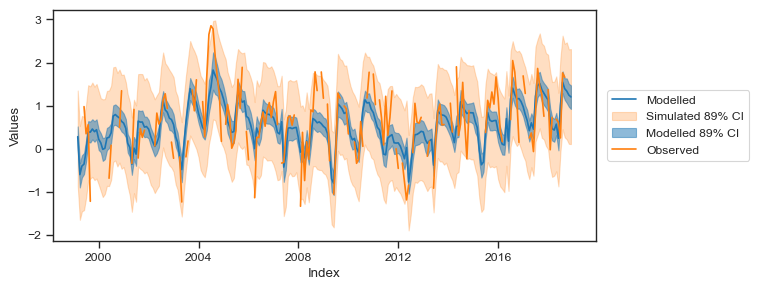

################################################################################
linear_shladj_model - Transect2


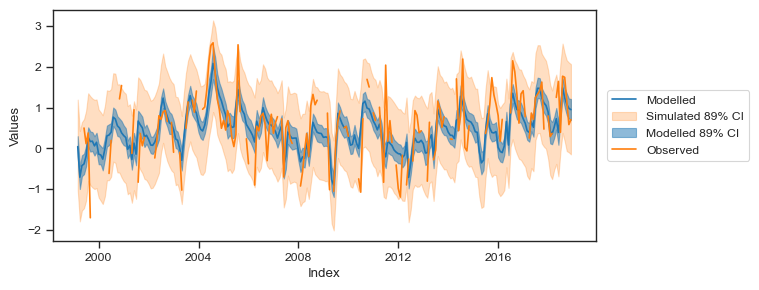

################################################################################
linear_shladj_model - Transect3


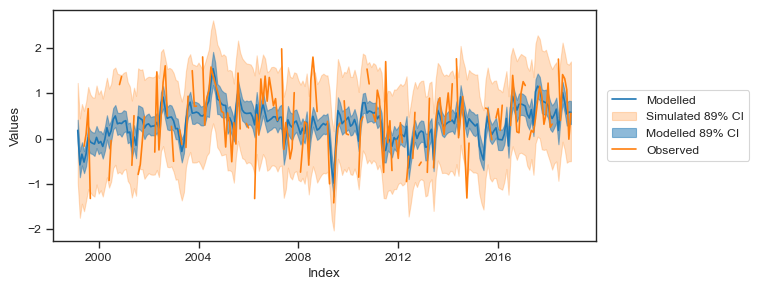

################################################################################
linear_shladj_model - Transect4


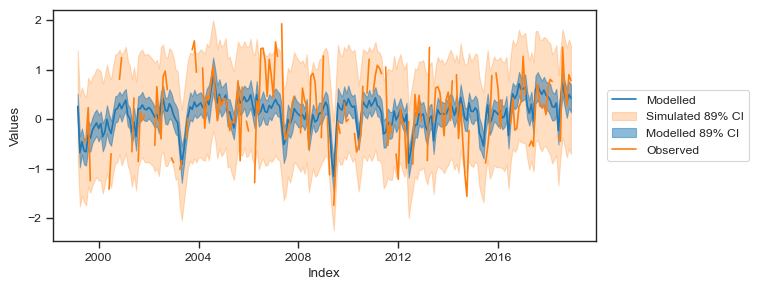

################################################################################
linear_shladj_model - Transect5


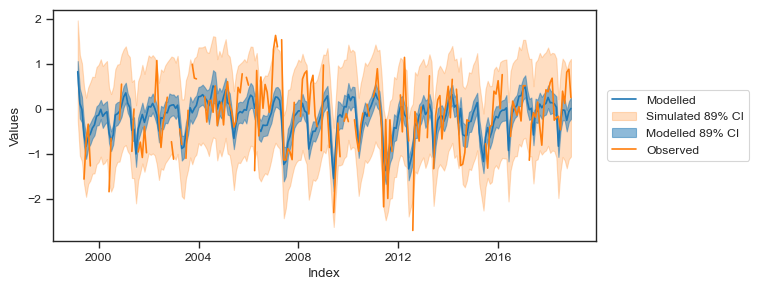

################################################################################
linear_shladj_model - Transect6


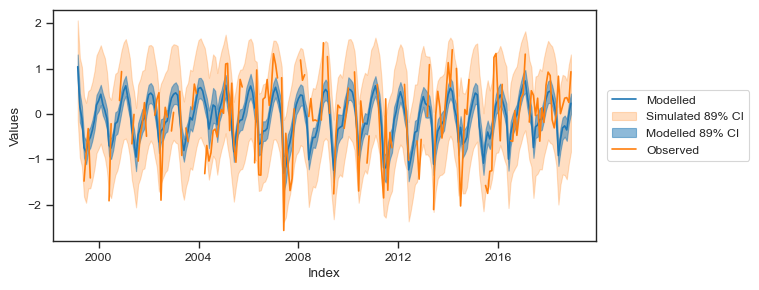

################################################################################
linear_shladj_model - Transect7


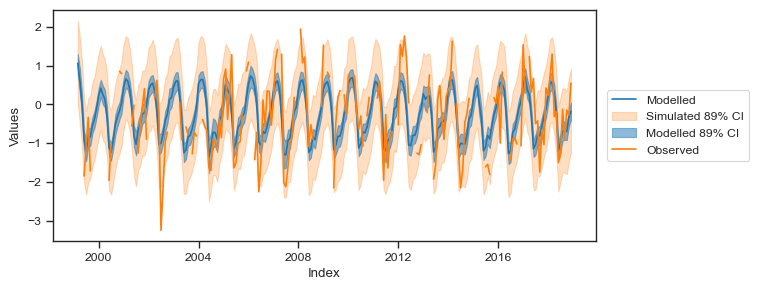

################################################################################
linear_shladj_model - Transect8


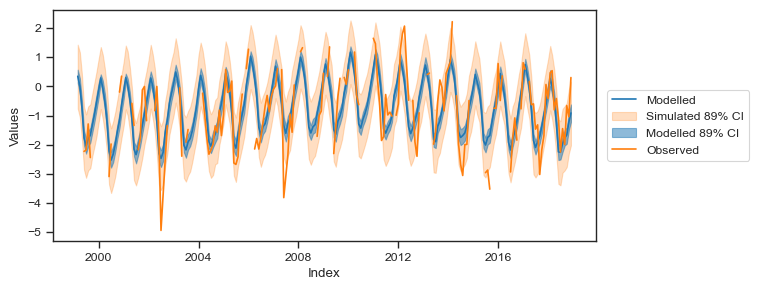

################################################################################
linear_shladj_model - Transect9


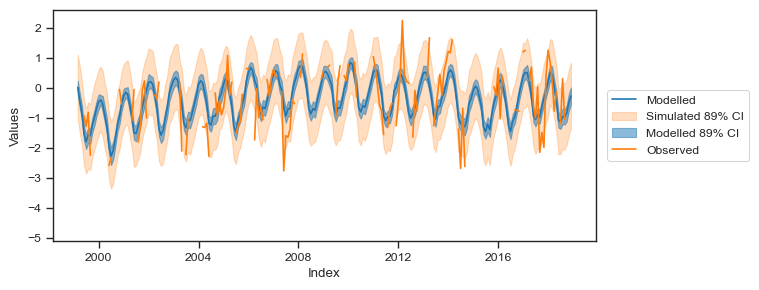

In [29]:
plot_models = mcmc_outputs.keys()

for tran_id, tran_name in enumerate(df_Y.columns):
    for this_model in plot_models:
        print('#'*80)
        print('{} - {}'.format(this_model, tran_name))
        plot_prediction(
            df_Y,
            mcmc_outputs[this_model]['mean_mu'],
            mcmc_outputs[this_model]['hpdi_mu'],
            mcmc_outputs[this_model]['hpdi_sim'],
            tran_id=tran_id,
            ci=ci
        )
        # plot_prediction_scatter(
        #     df_Y,
        #     mcmc_outputs[this_model]['mean_mu'],
        #     mcmc_outputs[this_model]['hpdi_mu'],
        #     mcmc_outputs[this_model]['hpdi_sim'],
        #     tran_id=1,
        #     ci=ci
        # )

################################################################################
Test: linear_shladj_model - Transect1


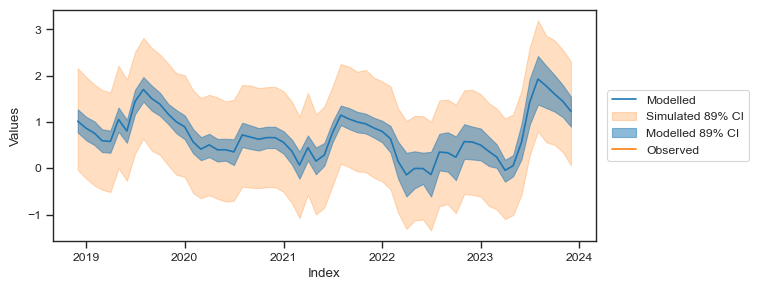

################################################################################
Test: linear_shladj_model - Transect2


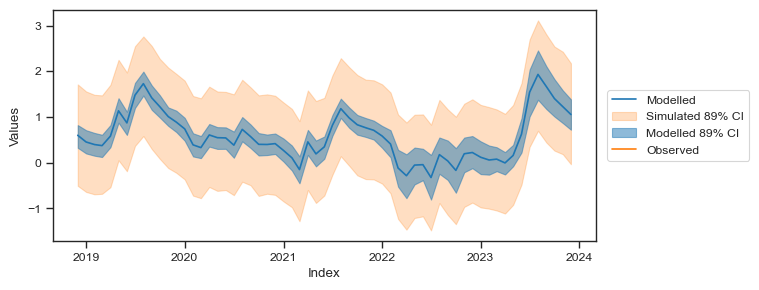

################################################################################
Test: linear_shladj_model - Transect3


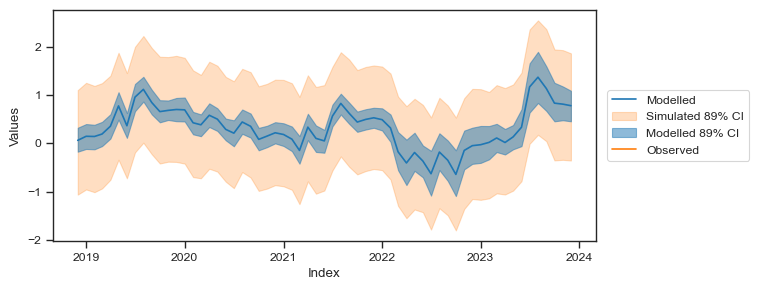

################################################################################
Test: linear_shladj_model - Transect4


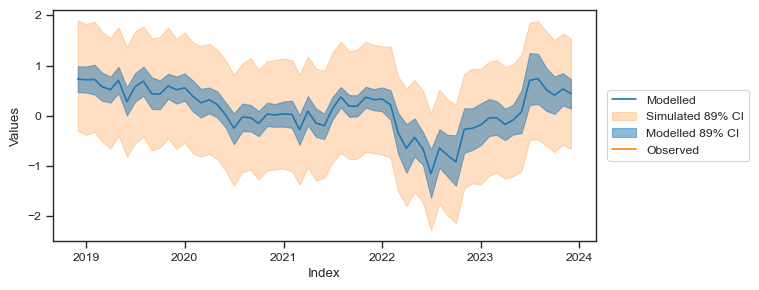

################################################################################
Test: linear_shladj_model - Transect5


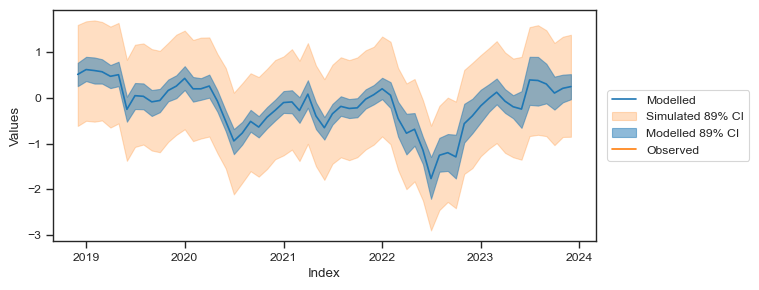

################################################################################
Test: linear_shladj_model - Transect6


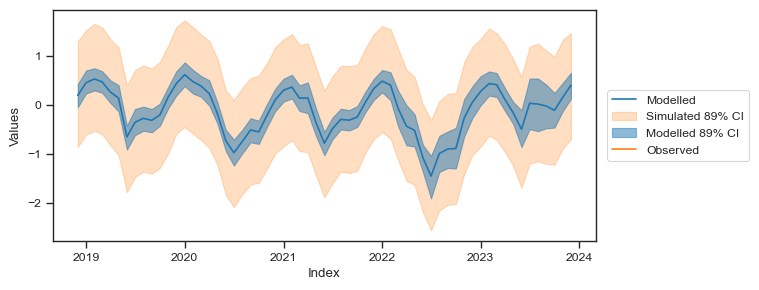

################################################################################
Test: linear_shladj_model - Transect7


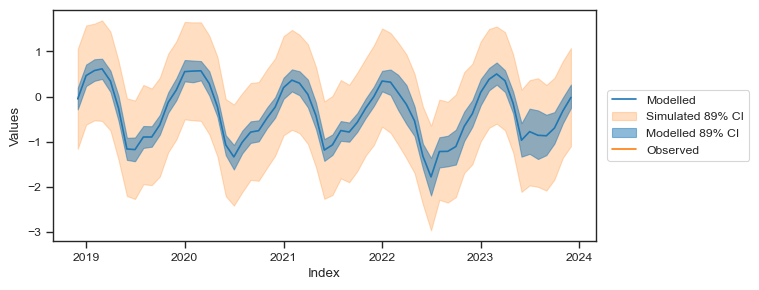

################################################################################
Test: linear_shladj_model - Transect8


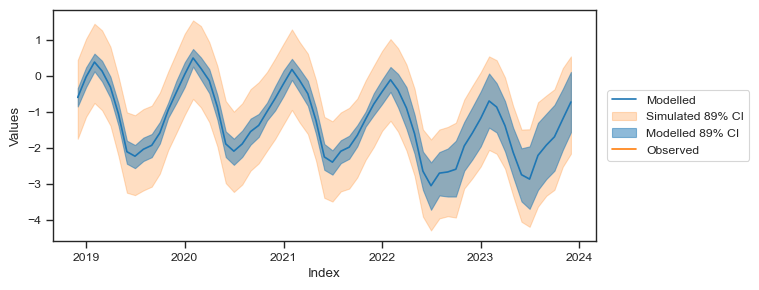

################################################################################
Test: linear_shladj_model - Transect9


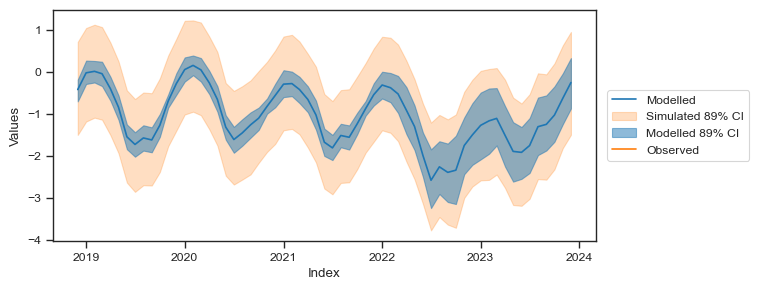

In [30]:
plot_models = mcmc_outputs.keys()
for tran_id, tran_name in enumerate(df_Y.columns):
    for this_model in plot_models:
        print('#'*80)
        print('Test: {} - {}'.format(this_model, tran_name))
        plot_prediction(
            df_Y_test,
            mcmc_outputs[this_model]['mean_mu_test'],
            mcmc_outputs[this_model]['hpdi_mu_test'],
            mcmc_outputs[this_model]['hpdi_sim_test'],
            tran_id=tran_id,
            ci=ci
        )

# Save results to share

In [31]:
scalers['scaler_y'].scale_

array([11.33626732])

In [32]:
mean_mu_out = pd.DataFrame(
    index = df_Y_test.index,
    columns = df_Y_test.columns,
    data = mcmc_outputs[this_model]['mean_mu_test'] * scalers['scaler_y'].scale_ + scalers['scaler_y'].mean_
)
mean_mu_out.index.name = 'Datetime'
mean_mu_out.to_csv('submissions/linear-but-a-smidge-fancy_JS/shorelines_prediction_{}.csv'.format(target_name),float_format='%.3f')
mean_mu_out

Transect     Transect1   Transect2   Transect3   Transect4   Transect5  \
Datetime                                                                 
2018-12-01  203.895681  199.166277  193.050027  200.629768  198.184126   
2019-01-01  202.178642  197.504421  193.999859  200.458659  199.380252   
2019-02-01  200.954607  196.871409  193.957580  200.552978  199.135162   
2019-03-01  199.120472  196.601665  194.529948  198.905459  198.837260   
2019-04-01  198.947131  198.960830  196.363842  198.221312  197.709018   
...                ...         ...         ...         ...         ...   
2023-08-01  214.230741  214.269818  207.851376  200.732614  196.672960   
2023-09-01  212.494526  211.258664  205.196712  198.234089  195.798193   
2023-10-01  210.585317  208.271376  201.768605  196.954417  193.555848   
2023-11-01  208.772774  206.269556  201.538059  198.380296  194.731331   
2023-12-01  206.317279  204.323385  201.173341  197.342397  195.162055   

Transect     Transect6   Transect7   Transect8   Transect9  
Datetime                                                    
2018-12-01  194.517105  191.797777  185.499967  187.564707  
2019-01-01  197.486078  197.631947  191.935777  192.057471  
2019-02-01  198.341809  198.901165  196.595403  192.458670  
2019-03-01  197.688075  199.328892  193.775081  191.815386  
2019-04-01  195.295770  196.251316  188.745170  187.780704  
...                ...         ...         ...         ...  
2023-08-01  192.523420  182.658530  167.284174  177.574951  
2023-09-01  192.068227  182.538837  170.506742  178.207151  
2023-10-01  191.064343  184.472163  173.122550  180.699930  
2023-11-01  194.110150  188.758676  178.719690  185.228323  
2023-12-01  196.883516  192.154495  184.054534  189.433732  

[61 rows x 9 columns]

## Save the model uncertainty

In [33]:
mean_mu_lower = pd.DataFrame(
    index = df_Y_test.index,
    columns = df_Y_test.columns + '_lower',
    data = mcmc_outputs[this_model]['hpdi_mu_test'][0,...] * scalers['scaler_y'].scale_ + scalers['scaler_y'].mean_
)
mean_mu_lower.index.name = 'Datetime'
mean_mu_upper = pd.DataFrame(
    index = df_Y_test.index,
    columns = df_Y_test.columns + '_upper',
    data = mcmc_outputs[this_model]['hpdi_mu_test'][1,...] * scalers['scaler_y'].scale_ + scalers['scaler_y'].mean_
)
mean_mu_upper.index.name = 'Datetime'

combined_out = pd.concat([mean_mu_lower,mean_mu_upper],axis=1)

combined_out.to_csv('submissions/linear-but-a-smidge-fancy_JS/shorelines_prediction_{}_model_uncertainty.csv'.format(target_name),float_format='%.3f')
combined_out

Transect    Transect1_lower  Transect2_lower  Transect3_lower  \
Datetime                                                        
2018-12-01       201.157939       196.062965       190.388885   
2019-01-01       199.254269       194.666193       191.028783   
2019-02-01       198.042353       194.101679       190.944564   
2019-03-01       196.346906       193.774347       191.703548   
2019-04-01       196.187770       196.214639       193.467988   
...                     ...              ...              ...   
2023-08-01       207.987562       207.982664       201.814274   
2023-09-01       207.130797       205.679948       199.943472   
2023-10-01       206.268576       203.821029       197.509397   
2023-11-01       204.902621       202.198937       197.760635   
2023-12-01       202.565467       200.547882       197.511040   

Transect    Transect4_lower  Transect5_lower  Transect6_lower  \
Datetime                                                        
2018-12-01       197.680123       195.263702       191.773214   
2019-01-01       197.574242       196.529021       194.995494   
2019-02-01       197.146837       195.906638       195.677002   
2019-03-01       195.721789       195.901202       195.155937   
2019-04-01       195.320835       194.783499       192.783166   
...                     ...              ...              ...   
2023-08-01       195.007776       190.441662       186.231238   
2023-09-01       193.452461       191.003187       186.912234   
2023-10-01       192.751103       189.454436       187.041243   
2023-11-01       194.657986       191.254991       190.918132   
2023-12-01       193.944255       192.019667       193.742078   

Transect    Transect7_lower  Transect8_lower  Transect9_lower  \
Datetime                                                        
2018-12-01       189.168860       182.645590       184.377014   
2019-01-01       195.022043       188.742035       189.064434   
2019-02-01       196.326248       193.671276       189.464168   
2019-03-01       196.805939       190.497449       188.493234   
2019-04-01       193.542865       185.357034       184.576379   
...                     ...              ...              ...   
2023-08-01       176.707197       156.413520       169.936331   
2023-09-01       177.692496       159.870763       171.171202   
2023-10-01       180.608607       162.467788       173.522986   
2023-11-01       185.655501       169.027033       178.253832   
2023-12-01       189.518589       174.567601       182.471828   

Transect    Transect1_upper  Transect2_upper  Transect3_upper  \
Datetime                                                        
2018-12-01       206.784370       201.697585       196.001508   
2019-01-01       204.972776       200.423195       196.866968   
2019-02-01       203.849022       199.752425       196.699922   
2019-03-01       201.904058       199.294677       197.376983   
2019-04-01       201.594436       201.700695       199.167967   
...                     ...              ...              ...   
2023-08-01       219.864528       220.220389       213.796353   
2023-09-01       217.448513       216.292641       210.389678   
2023-10-01       215.227826       213.089328       206.545347   
2023-11-01       212.748475       210.303583       205.687880   
2023-12-01       209.913688       208.078295       204.672724   

Transect    Transect4_upper  Transect5_upper  Transect6_upper  \
Datetime                                                        
2018-12-01       203.516329       201.050433       197.146589   
2019-01-01       203.436805       202.539963       200.333565   
2019-02-01       203.851158       202.374223       200.824829   
2019-03-01       202.066107       201.938907       200.158405   
2019-04-01       201.191594       200.504488       198.030004   
...                     ...              ...              ...   
2023-08-01       206.339921       202.526134       198.451725   
2023-09-01       203.111938    

## Save the model and data uncertainty

In [34]:
mean_mu_lower = pd.DataFrame(
    index = df_Y_test.index,
    columns = df_Y_test.columns + '_lower',
    data = mcmc_outputs[this_model]['hpdi_sim_test'][0,...] * scalers['scaler_y'].scale_ + scalers['scaler_y'].mean_
)
mean_mu_lower.index.name = 'Datetime'
mean_mu_upper = pd.DataFrame(
    index = df_Y_test.index,
    columns = df_Y_test.columns + '_upper',
    data = mcmc_outputs[this_model]['hpdi_sim_test'][1,...] * scalers['scaler_y'].scale_ + scalers['scaler_y'].mean_
)
mean_mu_upper.index.name = 'Datetime'

combined_out = pd.concat([mean_mu_lower,mean_mu_upper],axis=1)

combined_out.to_csv('submissions/linear-but-a-smidge-fancy_JS/shorelines_prediction_{}_modelplusdata_uncertainty.csv'.format(target_name),float_format='%.3f')

combined_out

Transect    Transect1_lower  Transect2_lower  Transect3_lower  \
Datetime                                                        
2018-12-01       191.966852       186.625657       180.329852   
2019-01-01       189.848005       185.114270       181.542337   
2019-02-01       188.161197       184.523459       180.900012   
2019-03-01       187.123976       184.645163       181.775915   
2019-04-01       186.549601       186.287652       183.820041   
...                     ...              ...              ...   
2023-08-01       201.416004       200.291191       194.352438   
2023-09-01       198.703819       197.382355       192.845490   
2023-10-01       198.122049       195.364979       188.351346   
2023-11-01       196.302221       194.475211       188.482671   
2023-12-01       193.098599       191.982128       188.322838   

Transect    Transect4_lower  Transect5_lower  Transect6_lower  \
Datetime                                                        
2018-12-01       188.902783       185.393203       182.515065   
2019-01-01       188.018812       186.679554       185.474836   
2019-02-01       188.712915       186.458185       186.285696   
2019-03-01       186.529039       186.763564       185.542722   
2019-04-01       184.964221       184.997469       182.966265   
...                     ...              ...              ...   
2023-08-01       186.948748       183.199384       179.277123   
2023-09-01       185.530999       182.865929       178.590849   
2023-10-01       184.130253       180.632986       178.471160   
2023-11-01       185.859935       182.665556       182.161861   
2023-12-01       184.813416       182.707045       184.373680   

Transect    Transect7_lower  Transect8_lower  Transect9_lower  \
Datetime                                                        
2018-12-01       179.251999       172.506702       175.362774   
2019-01-01       185.334452       179.423665       178.952709   
2019-02-01       186.414203       183.750091       180.004707   
2019-03-01       186.260175       181.481856       179.459455   
2019-04-01       183.861365       176.649471       175.312287   
...                     ...              ...              ...   
2023-08-01       169.729479       151.179841       163.485732   
2023-09-01       168.793524       154.600627       163.329471   
2023-10-01       171.572353       156.468513       166.092539   
2023-11-01       176.985308       163.725728       171.820723   
2023-12-01       179.938494       167.799083       175.386549   

Transect    Transect1_upper  Transect2_upper  Transect3_upper  \
Datetime                                                        
2018-12-01       216.876706       211.792341       204.825134   
2019-01-01       214.723590       210.039375       206.530993   
2019-02-01       212.858786       209.204281       205.803735   
2019-03-01       211.520293       209.070456       206.454984   
2019-04-01       210.922293       211.693983       208.200059   
...                     ...              ...              ...   
2023-08-01       228.574794       227.667142       221.160029   
2023-09-01       224.813226       224.198301       219.102261   
2023-10-01       223.737342       221.180240       214.355048   
2023-11-01       221.389970       219.891578       214.196146   
2023-12-01       218.498753       217.029918       213.442163   

Transect    Transect4_upper  Transect5_upper  Transect6_upper  \
Datetime                                                        
2018-12-01       213.857522       210.444519       207.072010   
2019-01-01       213.015776       211.344172       209.647847   
2019-02-01       213.601585       211.568578       211.139368   
2019-03-01       211.357190       211.191249       210.310054   
2019-04-01       209.879320       210.039712       207.565783   
...                     ...              ...              ...   
2023-08-01       213.661419       210.380568       206.504291   
2023-09-01       211.419405    